# Transformations and coordinate systems

In this notebook, we will describe some usage principles for *transformations* and *coordinate systems* in {class}`spatialdata.SpatialData`.

Let's first import some useful libraries and define a simple function to plot the data downstream.

In [1]:
import math

import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import numpy as np
import scipy
from skimage.segmentation import slic
from spatialdata import SpatialData
from spatialdata._core._spatialdata_ops import (
    get_transformation,
    get_transformation_between_coordinate_systems,
    set_transformation,
)
from spatialdata._core.models import Image2DModel, Labels2DModel, ShapesModel
from spatialdata._core.transformations import (
    Affine,
    Identity,
    MapAxis,
    Scale,
    Sequence,
    Translation,
)


def plot_raccoon(sdata, split: bool = False, transform: bool = False):
    def plot_translation(transform_image, im_ax, ax):
        mpl_transform = mtransforms.Affine2D().translate(transform_image.translation[0], transform_image.translation[1])
        trans_data = mpl_transform + ax.transData
        im_ax.set_transform(trans_data)

        # display intended extent of the image
        x1, x2, y1, y2 = im_ax.get_extent()
        ax.plot([x1, x2, x2, x1, x1], [y1, y1, y2, y2, y1], "y--", transform=trans_data)

    image_elem = sdata.images["raccoon"]
    labels_elem = sdata.labels["segmentation"]
    shapes_elem = sdata.shapes["circles"]
    if transform:
        transform_image = get_transformation(sdata.images["raccoon"])
        image_elem = transform_image.transform(image_elem)
        transform_labels = get_transformation(sdata.labels["segmentation"])
        labels_elem = transform_labels.transform(labels_elem)
        transform_shapes = get_transformation(sdata.shapes["circles"])
        shapes_elem = transform_shapes.transform(shapes_elem)
    else:
        transform_image = None
        transform_labels = None
        transform_shapes = None
    image = image_elem.transpose("y", "x", "c").data
    labels = labels_elem.data
    shapes = shapes_elem
    if split:
        _, ax = plt.subplots(1, 3, figsize=(8, 5))
        im_ax = ax[0].imshow(image)
        if isinstance(transform_image, Translation):
            plot_translation(transform_image, im_ax, ax[0])
        ax[1].imshow(labels, alpha=0.7)
        ax[2].scatter(
            shapes.geometry.x,
            shapes.geometry.y,
            s=shapes.radius,
            color="orange",
        )
        ax[2].set_aspect("equal")
        ax[2].set_xlim(ax[1].get_xlim())
        ax[2].set_ylim(ax[1].get_ylim())
    else:
        _, ax = plt.subplots(1, 1, figsize=(8, 5))
        im_ax = ax.imshow(image)
        if isinstance(transform_image, Translation):
            plot_translation(transform_image, im_ax, ax)
        ax.imshow(labels, alpha=0.7)
        ax.scatter(
            shapes.geometry.x,
            shapes.geometry.y,
            s=shapes.radius,
            color="orange",
        )
    plt.tight_layout()


%load_ext autoreload
%autoreload 2
%load_ext lab_black

/Users/giovanni.palla/miniconda3/envs/sdata/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/Users/giovanni.palla/miniconda3/envs/sdata/lib/python3.10/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()


We will now genereate a dummy dataset to showcase the usage of transformations and coordinate systems, that consits of:

- an image
- a segmentation mask
- few circles

We will generate this data and parse it with the spatialdata models, using in particular the {class}`spatialdata.models.Image2DModel`, {class}`spatialdata.models.Labels2DModel` and {class}`spatialdata.models.ShapesModel`.

Let's generate and parse the image

INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('c', 'y', 'x').                           


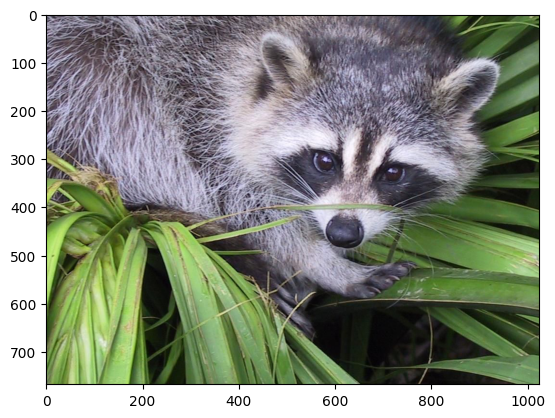

In [2]:
im_data = scipy.misc.face()
im = Image2DModel.parse(im_data, dims=["y", "x", "c"])
plt.imshow(im.transpose("y", "x", "c").data)

Let's generate and parse the labels (for this we'll use the {meth}`skimage.segmentation.slic` algorithm).

INFO     Transposing `data` of type: <class 'dask.array.core.Array'> to ('y', 'x').                                


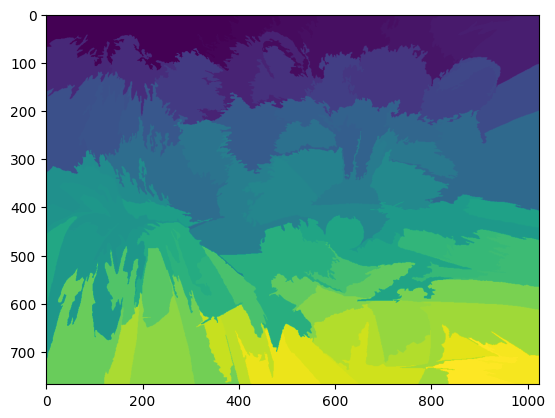

In [3]:
labels_data = slic(im_data, n_segments=100, compactness=10, sigma=1)
labels = Labels2DModel.parse(labels_data, dims=["y", "x"])
plt.imshow(labels)

And circles

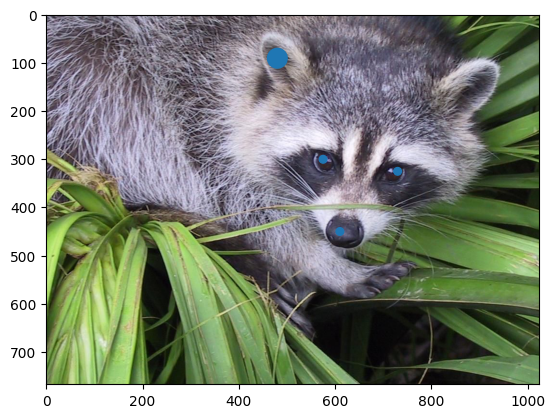

In [4]:
coords = np.array([[610, 450], [730, 325], [575, 300], [480, 90]])
circles = ShapesModel.parse(coords, geometry=0, radius=np.array([30, 30, 30, 200]))
plt.imshow(im.transpose("y", "x", "c").data)
plt.scatter(circles.geometry.x, circles.geometry.y, s=circles.radius)

We can finally create the {class}`spatialdata.SpatialData` object and plot it.

SpatialData object with:
├── Images
│     └── 'raccoon': SpatialImage[cyx] (3, 768, 1024)
├── Labels
│     └── 'segmentation': SpatialImage[yx] (768, 1024)
└── Shapes
      └── 'circles': GeoDataFrame shape: (4, 2) (2D shapes)
with coordinate systems:
▸ 'global', with elements:
        raccoon (Images), segmentation (Labels), circles (Shapes)


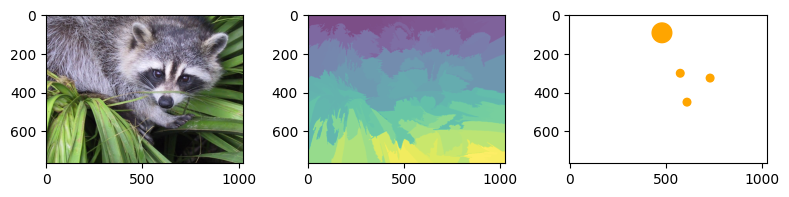

In [5]:
sdata0 = SpatialData(images={"raccoon": im}, labels={"segmentation": labels}, shapes={"circles": circles})
print(sdata0)

plot_raccoon(sdata0, split=True)

## Transformations and coordinate systems

From the `repr` printed above, you can already see that the `SpatialData` object has a `coordinate_system` attribute, which is a {class}`spatialdata.coordinate_systems.CoordinateSystem` object.

The `coordinate_systems` defines the coordinate system of the data, and they store the transformations needed for the element to be converted to the coordinate system.
At the moment, there is coordinate system available: `global`. In this coordinate system, there are 3 elements:

- `raccoon`: the raccoon image.
- `segmentation`: the segmentation mask.
- `circles`: the circles.

This is the default coordinate system that is added at the parsing stage, if no other transformation is specified. We can also expect that they are all {class}`spatialdata.transformations.Identity` transformations.
Let's print the availale coordinate systems in the SpatialData object and the transformations.

In [6]:
print(sdata0.coordinate_systems)
print(
    get_transformation(sdata0.images["raccoon"]),
    get_transformation(sdata0.labels["segmentation"]),
    get_transformation(sdata0.shapes["circles"]),
)

['global']
Identity  Identity  Identity 


Now that we understood what is a transformation and what is a coordinate system, let's see how we can use them.

Let's start by creating a new transformation, a simple {class}`spatialdata.transformations.Scale`. This transformation will scale the `"x"` axis by a factor of 2.

In [7]:
scale = Scale([2.0], axes=("x",))
set_transformation(sdata0.images["raccoon"], scale, to_coordinate_system="global")

Let's now plot the transformed element. We will do it step by step with `matplotlib` to understand what is happening. Later on, we will use the `plot_raccoon` helper function we defined above, with the argument `transform=True`, which is doing the same thing.

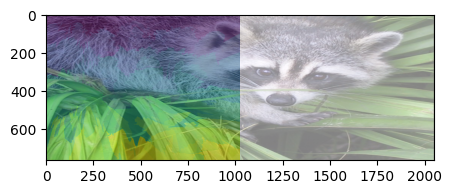

In [8]:
image_transform = get_transformation(sdata0.images["raccoon"])  # get the transformation for the image
im = image_transform.transform(sdata0.images["raccoon"])  # transform the image
labels_transform = get_transformation(sdata0.labels["segmentation"])  # get the transformation for the labels
lab = labels_transform.transform(sdata0.labels["segmentation"])  # transform the labels

_, ax = plt.subplots(1, 1, figsize=(5, 3))

ax.imshow(lab.data)
ax.imshow(im.transpose("y", "x", "c").data, alpha=0.5)
plt.show()

Notice that we passed the elements as is. The transformation API is able to understand what is the type of element as well as how the transformation should be applied to it.

The helper function we defined above does exactly the same thing, but it is a bit more convenient to use.

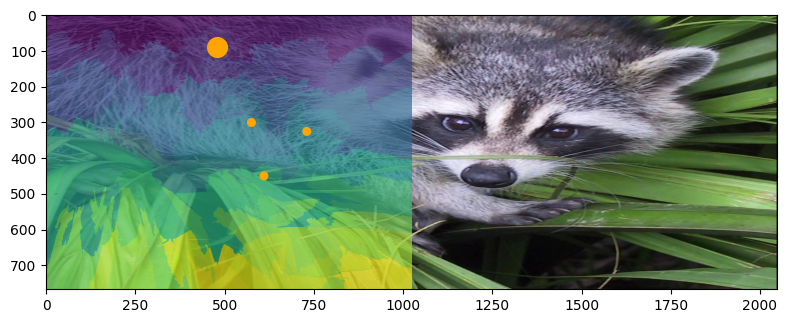

In [9]:
plot_raccoon(sdata0, transform=True)

## Various transformations

Let's now explore various transformations available in `SpatialData`.

### MapAxis

The {class}`spatialdata.transformations.MapAxis` transformation can be used to permute the axis of the elements.

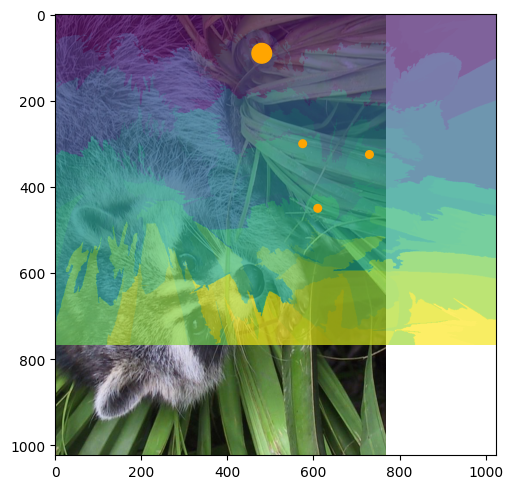

In [10]:
map_axis = MapAxis({"x": "y", "y": "x"})
set_transformation(sdata0.images["raccoon"], map_axis, to_coordinate_system="global")
plot_raccoon(sdata0, transform=True)

### Rotation

The {class}`spatialdata.transformations.Affine` transformation can be used to apply an affine transformation to the elements. Let's start with a rotation.

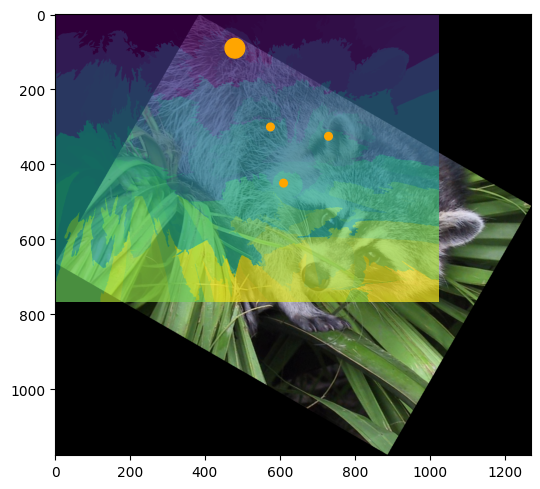

In [11]:
theta = math.pi / 6
rotation = Affine(
    [
        [math.cos(theta), -math.sin(theta), 0],
        [math.sin(theta), math.cos(theta), 0],
        [0, 0, 1],
    ],
    input_axes=("x", "y"),
    output_axes=("x", "y"),
)
set_transformation(sdata0.images["raccoon"], rotation, to_coordinate_system="global")
plot_raccoon(sdata0, transform=True)

### Translation

The {class}`spatialdata.transformations.Translation` transformation can be used to apply a translation to the element.

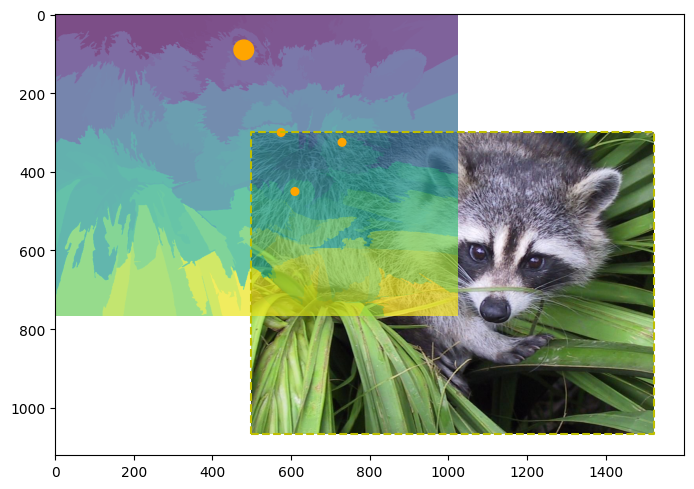

In [12]:
translation = Translation([500, 300], axes=("x", "y"))
set_transformation(sdata0.images["raccoon"], translation, to_coordinate_system="global")
plot_raccoon(sdata0, transform=True)

### Affine transformation and composition

The {class}`spatialdata.transformations.Sequence` transformation class can be used to compose transformations. This class allows to compose multiple transformations and it can be used even when the axes do not strictly match.

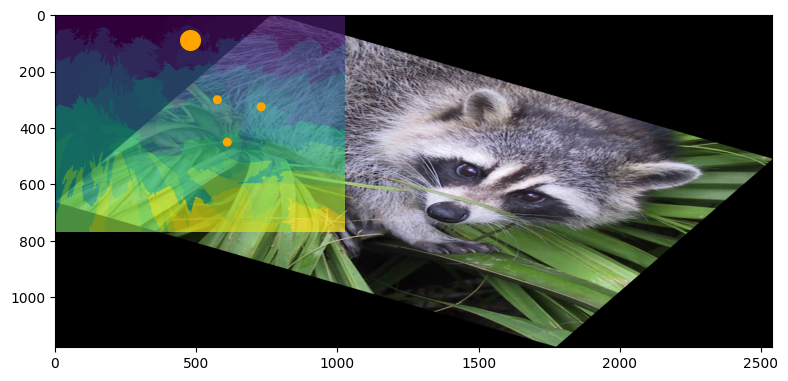

In [13]:
sequence = Sequence([rotation, scale])
set_transformation(sdata0.images["raccoon"], sequence, to_coordinate_system="global")
plot_raccoon(sdata0, transform=True)

We can also visualize the resulting affine matrix of the transformation.

In [14]:
print(sequence.to_affine_matrix(input_axes=("x", "y"), output_axes=("x", "y")))

[[ 1.73205081 -1.          0.        ]
 [ 0.5         0.8660254   0.        ]
 [ 0.          0.          1.        ]]


As shown before, transformations can be applied to various elements without the constraint that the axes must match.
For example, a {class}`spatialdata.transformations.Scale` transformation over axis `"x"` can be applied both to circles and to images.

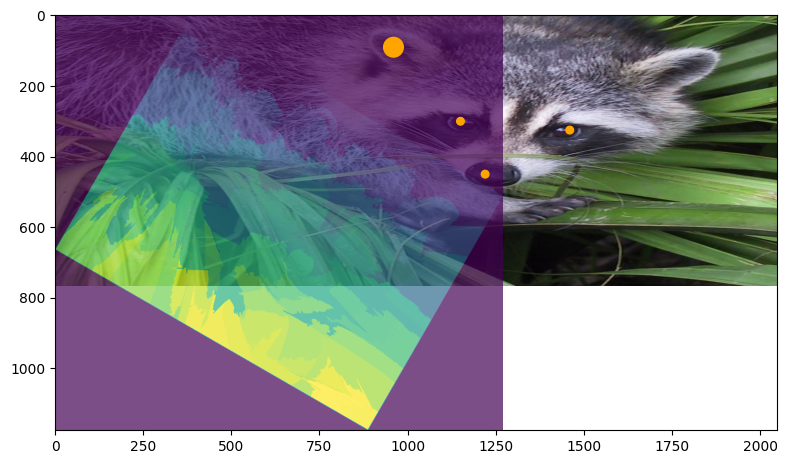

In [15]:
set_transformation(sdata0.images["raccoon"], scale, to_coordinate_system="global")
set_transformation(sdata0.shapes["circles"], scale, to_coordinate_system="global")
set_transformation(sdata0.labels["segmentation"], rotation, to_coordinate_system="global")
plot_raccoon(sdata0, transform=True)

### Inverse transformations

Most of the transformations also have an `inverse` method that returns the inverse transformation. If composed, they effectively cancel each other out.

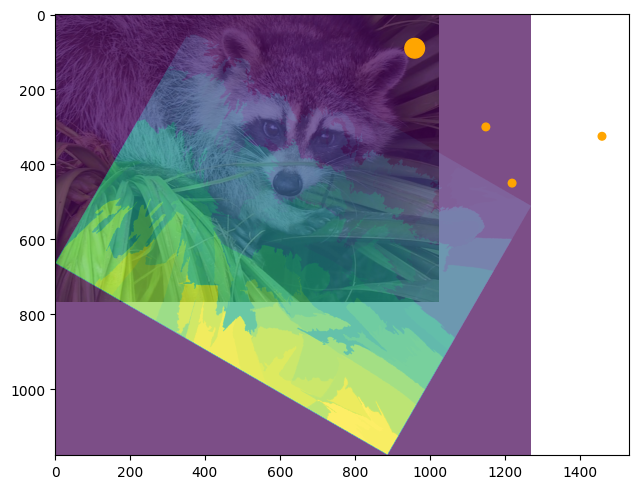

In [16]:
sequence = Sequence([rotation, rotation.inverse(), scale, scale.inverse()])
set_transformation(sdata0.images["raccoon"], sequence, to_coordinate_system="global")
plot_raccoon(sdata0, transform=True)

### Transformations and Axes

A transformation object can also retrieved the affine matrix with the {meth}`spatialdata.transformations.Transformation.to_affine_matrix` method. 
This method takes as input the axes of the input element and the axes of the output element. The affine matrix is built consistently according to the input and output axes.

Let's see an example.

In [17]:
print(translation.to_affine_matrix(input_axes=("x", "y"), output_axes=("x", "y")))
print(translation.to_affine_matrix(input_axes=("x", "y", "z"), output_axes=("x", "y", "z")))

[[  1.   0. 500.]
 [  0.   1. 300.]
 [  0.   0.   1.]]
[[  1.   0.   0. 500.]
 [  0.   1.   0. 300.]
 [  0.   0.   1.   0.]
 [  0.   0.   0.   1.]]


The affine matrix is built consistently according to the input and output axes.

The axes at input and output can also have mismatch and the affine matrix will be built accordingly.

In [18]:
print(translation.to_affine_matrix(input_axes=("x", "y", "c"), output_axes=("c", "z", "y", "x")))

[[  0.   0.   1.   0.]
 [  0.   0.   0.   0.]
 [  0.   1.   0. 300.]
 [  1.   0.   0. 500.]
 [  0.   0.   0.   1.]]


notice that z doesn't appear in the output axes since it was not in the input axes, but c is passed through since it was in the input axes
This is the same matrix that gets printed as output above.

|   | x | y | c |   |
|----|---|---|---|---|
| c | 0 | 0 | 1 | 0 |
| z | 0 | 0 | 0 | 0 | |
| y | 0 | 1 | 0 | 300 |
| x | 1 | 0 | 0 | 500 |
|   | 0 | 0 | 0 | 1 |

### Transformations between coordinate systems

`SpatialData` also allows to transform elements between coordinate systems. This is done by using the {func}`spatialdata.ops.get_transformation_between_coordinate_systems` function.
The function takes as argument the `SpatialData` object and the names of the coordinate systems. 
It returns the transformation that needs to be applied to the elements in the first coordinate system to be converted to the second coordinate system.

Let's see an example.


In [19]:
set_transformation(sdata0.images["raccoon"], rotation)
print(get_transformation_between_coordinate_systems(sdata0, sdata0.images["raccoon"], "global"))
print(get_transformation_between_coordinate_systems(sdata0, "global", sdata0.images["raccoon"]))

Sequence 
    Affine (x, y -> x, y)
        [ 0.8660254 -0.5        0.       ]
        [0.5       0.8660254 0.       ]
        [0. 0. 1.]
Sequence 
    Affine (x, y -> x, y)
        [0.8660254 0.5       0.       ]
        [-0.5        0.8660254  0.       ]
        [0. 0. 1.]


In the example above, we are effectively only returning the transformation that is needed to convert the elements in the `global` coordinate system to the `global` coordinate system (itself).
You can however notice that one transformation is the transpose of the other.

But as mentioned, the function can be used to transform elements between different coordinate systems. Let's see an example.
We first need to create a new coordinate system for some of the elements. We will just assign an {class}`spatialdata.transformations.Identity` trasnfomation.

In [20]:
set_transformation(sdata0.images["raccoon"], Identity(), "my_other_space0")
set_transformation(sdata0.labels["segmentation"], Identity(), "my_other_space1")
print(get_transformation(sdata0.images["raccoon"], get_all=True))
print(sdata0.coordinate_systems)

{'global': Affine (x, y -> x, y)
    [ 0.8660254 -0.5        0.       ]
    [0.5       0.8660254 0.       ]
    [0. 0. 1.], 'my_other_space0': Identity }
['my_other_space0', 'global', 'my_other_space1']


We then get the transformation between the `"global"` coordinate system and the `"my_other_space0"` coordinate system.

As expected, it is a {class}`spatialdata.transformations.Sequence` transformation with an {class}`spatialdata.transformations.Affine` and an {class}`spatialdata.transformations.Identity` composed.

In [21]:
get_transformation_between_coordinate_systems(sdata0, "global", "my_other_space0")

Sequence 
    Affine (x, y -> x, y)
        [0.8660254 0.5       0.       ]
        [-0.5        0.8660254  0.       ]
        [0. 0. 1.]
    Identity 